<a href="https://colab.research.google.com/github/payaljain2003/ML/blob/main/GAN/cifar_10_gan_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GAN demo using cifar10 dataset**

A GAN comprises of a generator and a discriminator

A discriminator is a CNN that says whether a generated image is fake or real



In [1]:
#example of loading and plotting the cfar10 dataset
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot

In [2]:
(trainX, trainy),(testX, testy) = load_data()

170498071/170498071 [==============================] - 3s 0us/step


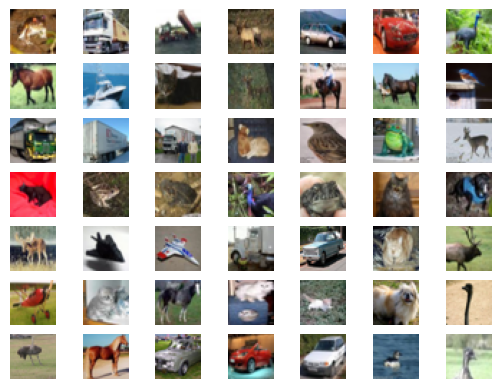

In [3]:
for i in range(49):
  pyplot.subplot(7,7,1+i)
  pyplot.axis("off")
  pyplot.imshow(trainX[i])
pyplot.show()

In [4]:
print(trainX.shape)

(50000, 32, 32, 3)


In [5]:
print(testX.shape)

(10000, 32, 32, 3)


**Code to make discriminator**

In [6]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU
from keras.utils.vis_utils import plot_model
import numpy as np

In [7]:
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  #normal
  model.add(Conv2D(64,(3,3),padding='same',input_shape = in_shape))
  model.add(LeakyReLU(alpha=0.2))

  #downsample
  model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  #downsample
  model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  #downsample
  model.add(Conv2D(256,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  #classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))


  opt = Adam(lr = 0.0002, beta_1 = 0.5)
  model.compile(loss='binary_crossentropy',optimizer = opt,metrics = ['accuracy'])
  return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


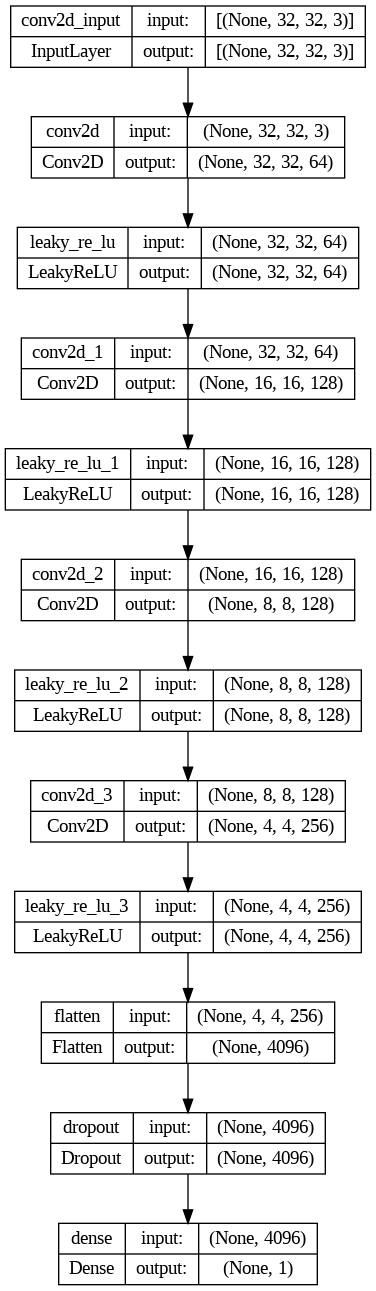

In [8]:
model = define_discriminator()
model.summary()
plot_model(model, to_file='discriminator_plot.png', show_shapes = True, show_layer_names = True)

In [9]:
def load_real_sample():
  (trainX,_),(_,_) = load_data()
  X = trainX.astype('float32')
  #to scale values between [-1,1] because the activation function used wiill be tanh
  X = (X-127.5)/127.5
  return X

In [10]:
X = load_real_sample()
X.shape

(50000, 32, 32, 3)

In [11]:
def generate_real_samples(dataset,n_samples):
  ix = np.random.randint(0,dataset.shape[0], n_samples)
  X = dataset[ix]
  y = np.ones((n_samples,1))
  return X, y

In [12]:
X, y = generate_real_samples(X,64)
print(X.shape)
print(y.shape)
print(y)

(64, 32, 32, 3)
(64, 1)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [13]:
def generate_fake_samples(n_samples):
  X =np.random.rand(32*32*3*n_samples)
  #the values will lie between [0,1)
  #scale the values between [-1,1)

  X = -1 + X * 2

  X =X.reshape((n_samples,32,32,3))
  y = np.zeros((n_samples,1))
  return X, y

In [14]:
X,y = generate_fake_samples(64)

In [15]:
print(X.shape)

(64, 32, 32, 3)


In [16]:
print(y.shape)

(64, 1)


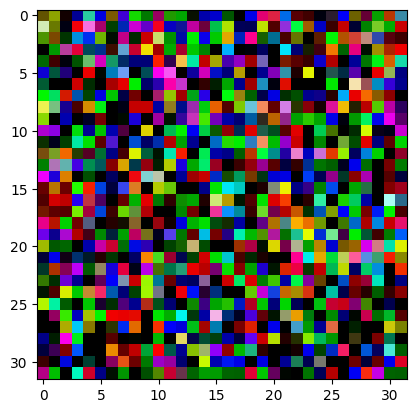

In [17]:
pyplot.imshow(X[0])

In [18]:
def train_discriminator(model,dataset, epochs = 20, n_batches=128):
  half_batch = int(n_batches/2)
  for i in range(epochs):
    X_real, y_real = generate_real_samples(dataset, half_batch)

    #update discriminator on real samples
    _,real_acc = model.train_on_batch(X_real,y_real)

    X_fake, y_fake = generate_fake_samples(half_batch)
    #update discriminator on fake samples

    _,fake_acc = model.train_on_batch(X_fake, y_fake)

    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100,fake_acc*100))



In [19]:
model = define_discriminator()
dataset =load_real_sample()
train_discriminator(model,dataset)

>1 real=53% fake=0%
>2 real=100% fake=5%
>3 real=98% fake=12%
>4 real=97% fake=34%
>5 real=98% fake=89%
>6 real=97% fake=97%
>7 real=97% fake=100%
>8 real=92% fake=100%
>9 real=94% fake=100%
>10 real=94% fake=100%
>11 real=98% fake=100%
>12 real=95% fake=100%
>13 real=95% fake=100%
>14 real=97% fake=100%
>15 real=98% fake=100%
>16 real=98% fake=100%
>17 real=100% fake=100%
>18 real=100% fake=100%
>19 real=100% fake=100%
>20 real=100% fake=100%


In [20]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

In [21]:
def define_generator(latent_dim):
  model = Sequential()
  n_nodes = 256*4*4

  #foundation for 4 X 4 image
  model.add(Dense(n_nodes, input_dim = latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4,4,256)))

  #upsample to 8 x 8
  model.add(Conv2DTranspose(128,(4,4), strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  #upsample to 16 x 16
  model.add(Conv2DTranspose(128,(4,4), strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  #upsample to 32 x 32
  model.add(Conv2DTranspose(128,(4,4), strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(3,(3,3), activation='tanh',padding='same'))
  return model


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

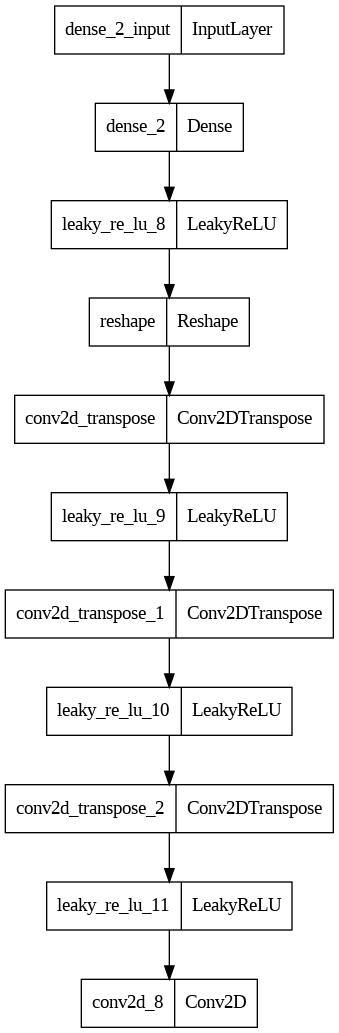

In [22]:
latent_dim = 100
model = define_generator(latent_dim)

model.summary()
plot_model(model, to_file = 'generator_plot.png', show_layer_names = True)

In [23]:
def generate_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)

  return x_input

In [24]:
def generate_fake_samples(g_model, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  X = g_model.predict(x_input)
  y = np.zeros((n_samples,1))
  return X, y

2/2 [==============================] - 0s 96ms/step


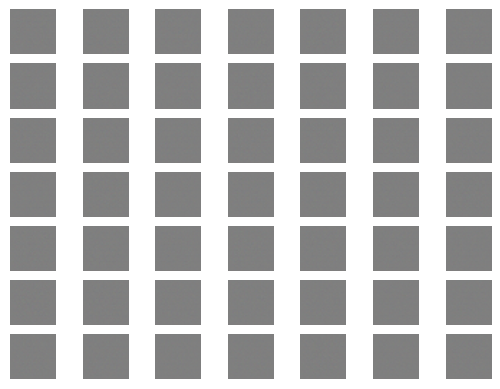

In [25]:
latent_dim =100

model = define_generator(latent_dim)
n_samples = 49

X,_ = generate_fake_samples(model, latent_dim, n_samples)

X = (X+1)/2.0

for i in range(n_samples):
  pyplot.subplot(7,7,i+1)
  pyplot.axis('off')
  pyplot.imshow(X[i])
pyplot.show()

In [26]:
def define_gan(g_model,d_model):
  d_model.trainable = False
  model = Sequential()
  model.add(g_model)
  model.add(d_model)

  opt = Adam(lr=0.0002, beta_1 = 0.5)
  model.compile(loss = 'binary_crossentropy',optimizer = opt)
  return model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


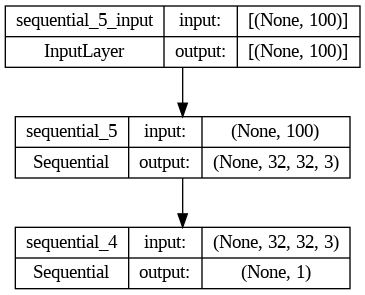

In [27]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)

gan_model.summary()

plot_model(gan_model, to_file ='gan_plot.png',show_shapes=True, show_layer_names=True)

In [28]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
  batch_per_epoch = int(dataset.shape[0]/n_batch)
  half_batch = int(n_batch/2)
  for i in range(n_epochs):
    for j in range(batch_per_epoch):
      X_real,y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      X_fake,y_fake = generate_fake_samples(g_model,latent_dim,half_batch)
      d_loss2, _ = g_model.train_on_batch(X_fake, y_fake)

      X_gan = generate_latent_points(latent_dim,n_batch)
      y_gan = np.ones((n_batch,1))

      g_loss = gan_model.train_on_batch(X_gan,y_gan)

      print('>%d, %d/%d, d1 = %.3f, d2 = %.3f g = %.3f' %
       (i+1,j+1,batch_per_epoch,d_loss1, d_loss2,g_loss))

    if (i+1)%10==0:
      summarize_perormance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples = 150):
  X_real, y_real = generate_real_samples(dataset, n_samples)
  _,acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)

  print('>Accuracy real : %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

  save_plot(X_fake, epoch)
  filename = 'generator_model_%03d.h5' % (epoch+1)
  j